# پرسش ۱

In [1]:
using Plots
using LinearAlgebra
using Statistics

function show_scatter(arr, marker = nothing, sz = nothing, rt = false)
    gr(legends = true)
    if isnothing(sz)
        gr()
    else
        gr(size = sz)
    end
    if isnothing(marker)
        pl = scatter(arr[:, 1], arr[:, 2])
        display(pl)
    else
        pl = scatter(arr[:, 1], arr[:, 2], marker_z = marker)
        display(pl)
    end
    if rt
        return pl
    end
end

# moons = 
# blobs = 

show_scatter (generic function with 4 methods)

In [2]:
function assign_centroids(X, centroids)
    d, n = size(X)
    assignments = zeros(Int64, n)
    errs = zeros(Float64, n)
    for i = 1:n
        errs[i], assignments[i] =
            findmin(mapslices(norm, centroids .- X[:, i], dims = 1)[1, :])
    end
    return assignments, errs
end

function calc_centroids(X, assignments, k)
    return hcat(
        [
            sum(X * (assignments .== i), dims = 2) /
            max(1, count(assignments .== i)) for i = 1:k
        ]...,
    )
end

function kmeans_clusterin(
    X::AbstractMatrix{<:Real}, # data matrix (d x n) columns
    k::Integer,
    maxiter::Integer = 100,
    tol::Real = 1.0e-6,
)
    d, n = size(X)
    assignments = zeros(Int64, n)
    bound_mx = maximum(X, dims = 2)
    bound_mn = minimum(X, dims = 2)
    centroids = rand((d, k)) .* (bound_mx - bound_mn) .+ bound_mn

    last_er = Inf
    diff_er = Inf
    t = 0
    while diff_er > tol && (t += 1) <= maxiter
        assignments, errs = assign_centroids(X, centroids)
        centroids = calc_centroids(X, assignments, k)
        erval = sum(errs)
        diff_er = last_er - erval
        last_er = erval
    end
    return assignments, last_er, t
end


kmeans_clusterin (generic function with 3 methods)

## آ)

برای پیدا کردن $k$ مناسب در روش $\text{k-means}$، دو روش معمول وجود دارد. روش اول، روش $\text{elbow}$ است که به نمودار خطای نهایی بر حسب $k$ توجه می‌کند و زمانی که اندازه مشتق این نمودار به اندازه کافی کاهش پیدا می‌کند، آن نقطه، نقطه مناسبی برای $k$ است. در نمودار اول، نمودار خطا بر حسب تعداد خوشه و در نمودار دوم مشتق نمودار قبل را می‌بینید. همانطور که به نظر می‌آید، $k=3$ یک مقدار مناسب برای خوشه‌بندی است. 

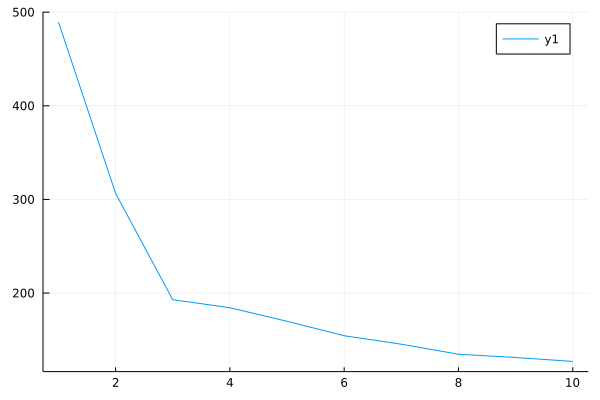

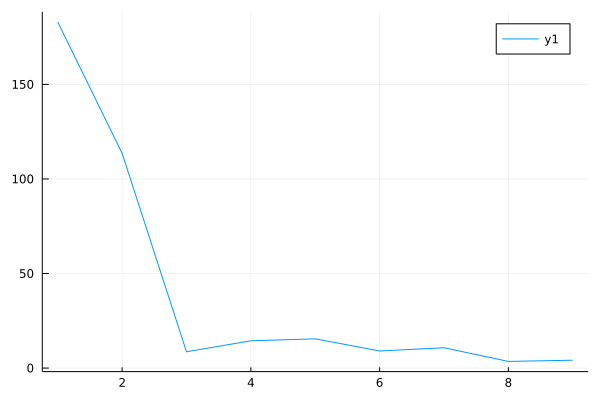

In [5]:
elbow = [kmeans_clusterin(collect((blobs)'), i)[2] for i = 1:10]
display(plot(elbow))
display(plot(elbow[1:end-1] - elbow[2:end]))

روش دیگر، روش $\text{silhoette}$ است که شباهت هر نقطه به خوشه‌اش در مقایسه با دیگر خوشه‌ها را بررسی می‌کند. هر نقطه یک امتیاز سیلوئت دارد که برابر با:

$$s(i) = \frac{b(i)-a(i)}{\max\{a(i),b(i)\}}$$

که در اینجا $a(i)$ میانگین فاصله نقطه $i$ با نقاط درون خوشه و $b(i)$ میانگین فاصله تا اعضای نزدیک‌ترین خوشه است.  
امتیاز هر نقطه عددی در $[-1,1]$ است که مقادیر بیشتر، نشان‌دهنده این است که خوشه مناسبی برای نقطه انتخاب شده است.  
امتیاز کل برابر با میانگین امتیاز همه نقطه‌هاست. ماکسیمم تابع، بهترین $k$ را نشان می‌دهد و همانطور که می‌بینید در این مورد ما، $k=3$ نقطه‌ای با بیشترین امتیاز است.

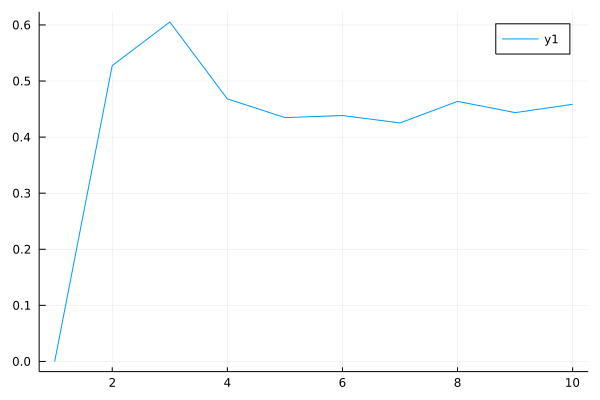

In [6]:
function silhouette_score(X, assignments)
    n = size(X)[2]
    k = maximum(assignments)
    if k <= 1
        return 0
    end
    res = 0
    for i = 1:n
        pt = X[:, i]
        c = count(assignments .== assignments[i])
        if c == 1
            continue
        end
        dists = mapslices(norm, X .- pt, dims = 1)
        a = sum(dists[assignments.==assignments[i]]) / (c - 1)
        b = minimum([
            sum(dists[assignments.==j]) / count(assignments .== j) for
            j = 1:k if j != assignments[i]
        ])
        res += (b - a) / max(a, b)
    end
    return res / n
end

silo = [
    silhouette_score(
        collect((blobs)'),
        kmeans_clusterin(collect((blobs)'), i)[1],
    ) for i = 1:10
]
display(plot(silo))

## ب)

همانطور که در بخش الف دیدیم، بهترین مقدار برای خوشه‌بندی، $k=3$ است.

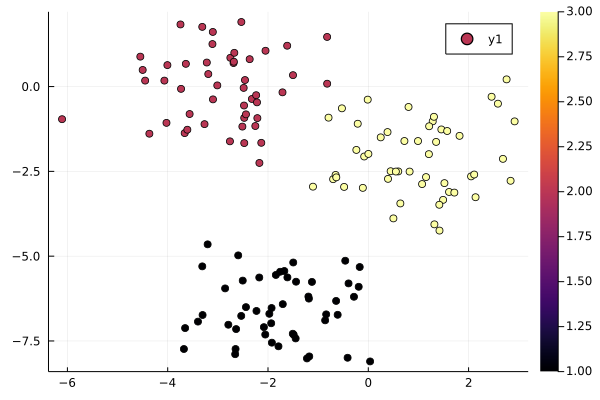

In [7]:
cluss_blobs, er, t = kmeans_clusterin(collect((blobs)'), 3)
show_scatter(blobs, cluss_blobs)

## پ)

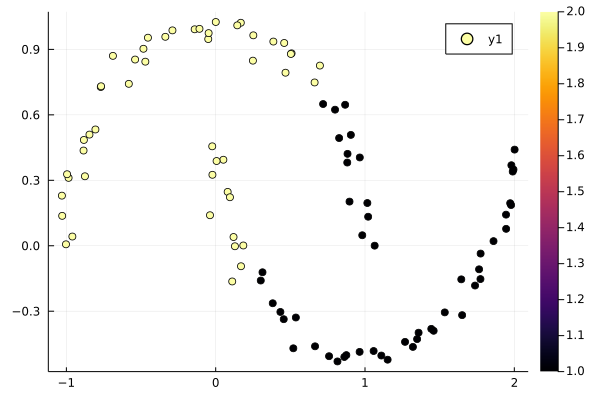

In [8]:
cluss_moons, er, t = kmeans_clusterin(collect((moons)'), 2)
show_scatter(moons, cluss_moons)

همانطور که مشاهده می‌کنید، این داده به خوبی خوشه‌بندی نمی‌شود چرا که با توجه به ماهیت روش $\text{k-means}$، خوشه‌ها باید توسط خطوط راست، جدایی‌پذیر باشند در حالی که برای این مجموعه داده، بین دو هلال چنین خطی وجود ندارد.

## ت)

برای خوشه بندی $\text{TwoMoons}$ باید از روش‌های مبتنی بر گراف و یا مبتنی بر تراکم استفاده کنیم. برای همین از روش خوشه‌بندی اسپکترال که در پرسش ۳ گفته شده استفاده می‌کنیم که گراف فاصله نقاط را برای تمامی جفت نقاط در نظر می‌گیریم که تابع نمایی روی آن‌ها اعمال شده تا تاثیر فواصل دور کمتر شود. سپس الگوریتم را روی آن اجرا می‌کنیم.

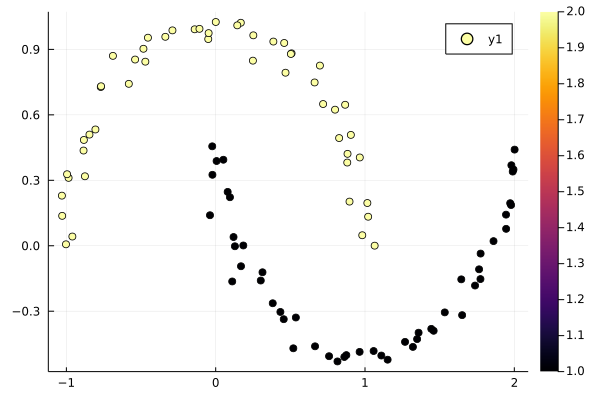

In [9]:
using Clustering

function get_dists(X)
    n = size(X)[2]
    return [norm(X[:, i] - X[:, j]) for i = 1:n, j = 1:n]
end

function get_laplacian(W)
    return diagm(sum(W, dims = 1)[1, :]) - W
end

function spectral_clustering(X, k, alpha = 10)
    L = get_laplacian(exp.(-alpha * get_dists(X)))
    spec = kmeans(collect((eigvecs(L)[:, 1:k])'), k)
    return spec.assignments
end

clus_spec = spectral_clustering(collect(moons'), 2)
show_scatter(moons, clus_spec)
